In [1]:
# Objective is to link up the devon dataset with a PV system in the area
# start off with predicting PV based on image, not including time series aspect

# Potentially useful tutorial here https://medium.com/analytics-vidhya/fastai-image-regression-age-prediction-based-on-image-68294d34f2ed
# Illinois converting data to numpy https://github.com/jmather625/climatehack/blob/main/data/download_data.ipynb

### 1. Importing data

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt

In [3]:
SATELLITE_ZARR_PATH = "./data/devon-crop.zarr"

dataset = xr.open_dataset(
    SATELLITE_ZARR_PATH, 
    engine="zarr",
    chunks="auto",  # Load the data as a Dask array
)

print(dataset)

<xarray.Dataset>
Dimensions:  (time: 173624, y: 100, x: 100)
Coordinates:
  * time     (time) datetime64[ns] 2020-01-01T00:05:00 ... 2021-11-07T15:50:00
  * x        (x) float32 -8.221e+05 -8.231e+05 ... -9.201e+05 -9.211e+05
    x_osgb   (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
  * y        (y) float32 4.523e+06 4.524e+06 4.525e+06 ... 4.621e+06 4.622e+06
    y_osgb   (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
Data variables:
    data     (time, y, x) int16 dask.array<chunksize=(3946, 100, 100), meta=np.ndarray>


In [5]:
pv_power = xr.open_dataset("data/uk_pv/pv.netcdf", engine="h5netcdf")
pv_power

<xarray.Dataset>
Dimensions:   (datetime: 387254)
Coordinates:
  * datetime  (datetime) datetime64[ns] 2018-01-01T06:05:00 ... 2021-10-27T23...
Data variables: (12/1311)
    10003     (datetime) float32 ...
    10004     (datetime) float32 ...
    10005     (datetime) float32 ...
    10048     (datetime) float32 ...
    10049     (datetime) float32 ...
    10063     (datetime) float32 ...
    ...        ...
    9870      (datetime) float32 ...
    9871      (datetime) float32 ...
    9902      (datetime) float32 ...
    9903      (datetime) float32 ...
    9960      (datetime) float32 ...
    9989      (datetime) float32 ...

In [7]:
# X: dataset            # cropped satellite image
# Y: devon_pv_df        # pv_yield

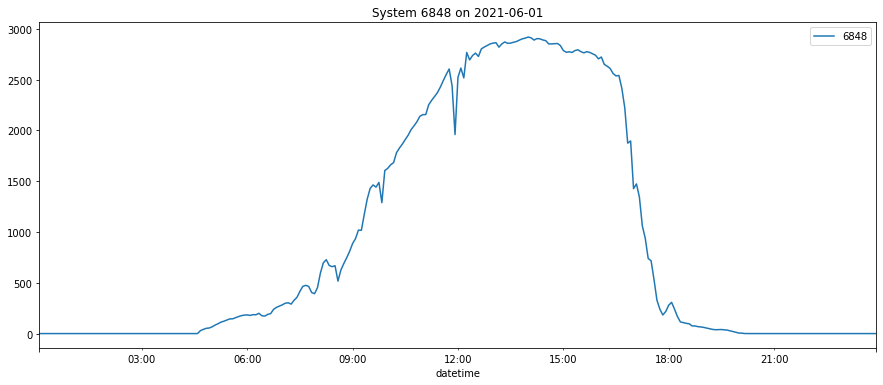

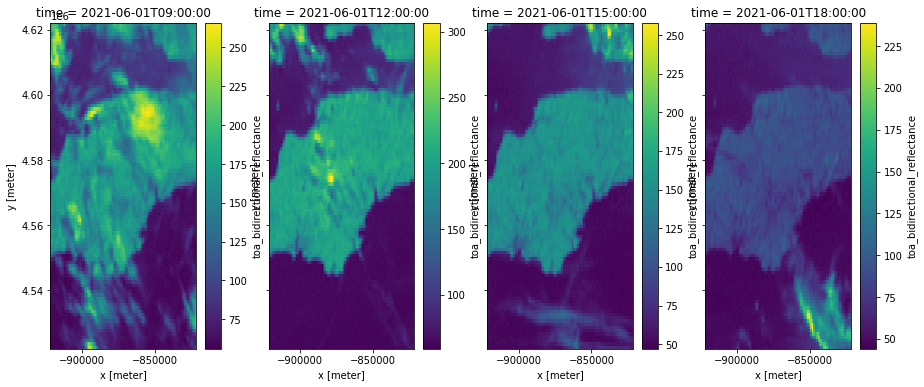

In [65]:
# Getting the images for one day

devon_pv_df = pv_power['6848'].to_dataframe()

# Goal is to get different images to match up with PV yield, maybe 4-8 over the course of a day

devon_pv_df = devon_pv_df[devon_pv_df.index < '2021-06-02']
devon_pv_df = devon_pv_df[devon_pv_df.index > '2021-06-01']

devon_pv_df.plot(figsize=(15,6))
plt.title('System 6848 on 2021-06-01');
plt.savefig('images/system_6848_pv_yield.jpg')

fig, axes = plt.subplots(ncols=4, sharey=True, sharex=True, figsize=(15,6))

dataset['data'].sel(time="2021-06-01 09:00").plot(ax=axes[0])
dataset['data'].sel(time="2021-06-01 12:00").plot(ax=axes[1])
dataset['data'].sel(time="2021-06-01 15:00").plot(ax=axes[2])
dataset['data'].sel(time="2021-06-01 18:00").plot(ax=axes[3]);

plt.savefig('images/system_6848_sat_frames.jpg')

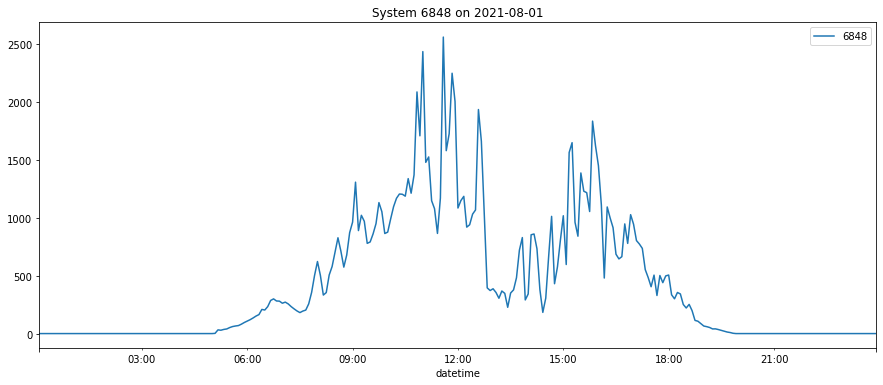

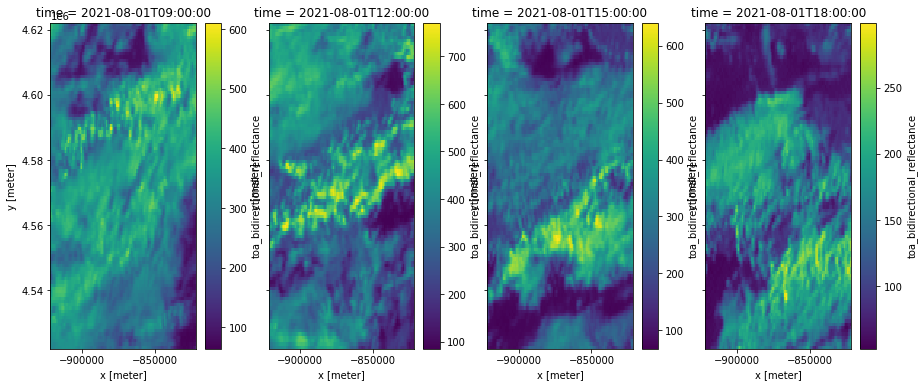

In [70]:
# A much clouder day, August 1st 2021

devon_pv_df = pv_power['6848'].to_dataframe()

# Goal is to get different images to match up with PV yield, maybe 4-8 over the course of a day

devon_pv_df = devon_pv_df[devon_pv_df.index < '2021-08-02']
devon_pv_df = devon_pv_df[devon_pv_df.index > '2021-08-01']

devon_pv_df.plot(figsize=(15,6))
plt.title('System 6848 on 2021-08-01')

fig, axes = plt.subplots(ncols=4, sharey=True, sharex=True, figsize=(15,6))

dataset['data'].sel(time="2021-08-01 09:00").plot(ax=axes[0])
dataset['data'].sel(time="2021-08-01 12:00").plot(ax=axes[1])
dataset['data'].sel(time="2021-08-01 15:00").plot(ax=axes[2])
dataset['data'].sel(time="2021-08-01 18:00").plot(ax=axes[3]);

### Data ranges

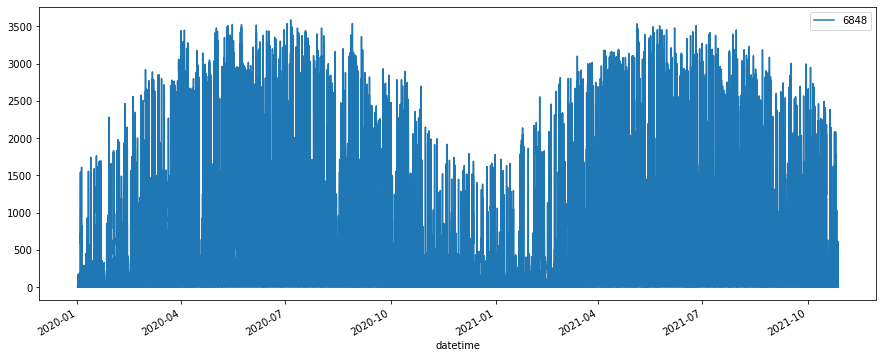

In [135]:
# PV yield is every 5 minutes, from 2018-01-01 to 2021-10-27, from 6am to 7pm

devon_pv_df = pv_power['6848'].to_dataframe()

# cropping for 2020-01-01 to 2021-11-07

devon_pv_df = devon_pv_df[devon_pv_df.index < '2021-11-07']
devon_pv_df = devon_pv_df[devon_pv_df.index > '2020-01-01']

# print(devon_pv_df.min(axis=1).head(2))
# print(devon_pv_df.max(axis=1))

devon_pv_df.plot(figsize=(15,6));


In [136]:
#devon_pv_df.drop(columns=1)
pv_times_list = devon_pv_df.index.tolist()
print('Number of PV readings :', len(pv_times_list))

# Satellite imagery is every 5 minutes, from 2020-01-01,to 2021-11-07, possibly all day

# the following seem to be equivalent : dataset['time'], and dataset['data'].time

sat_times_list = dataset['data'].time.to_dataframe().index.to_list()
print('Number of satellite images :', len(sat_times_list))

Number of PV readings : 191265
Number of satellite images : 173624


In [137]:
# Creating shared_timestamps - probably not a very efficient way of doing it, doing nested loops >100K large
# is there some way to tell python that the list is sorted? that would stop it checking all the values

shared_timestamps = []
sat_not_pv = 0
for i in sat_times_list:
    if i in pv_times_list:
        shared_timestamps.append(i)

In [152]:
import datetime

In [179]:
dataset["time"]

<xarray.DataArray 'time' (time: 173624)>
array(['2020-01-01T00:05:00.000000000', '2020-01-01T00:10:00.000000000',
       '2020-01-01T00:15:00.000000000', ..., '2021-11-07T15:40:00.000000000',
       '2021-11-07T15:45:00.000000000', '2021-11-07T15:50:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2020-01-01T00:05:00 ... 2021-11-07T15:50:00

In [182]:
# shared_timestamps[0:20]
# printing the shared_timestamps revealed I had timestamps at night when there was no readings

# cutting from 6am to 8pm will probably reduce the dataset by (10/24 =) 42% and I'll still have dark periods from winter for training

def get_day_slice(date):
    data_slice = dataset.loc[
        {
            # 6am to 8pm
            "time": slice(
                date + datetime.timedelta(hours=10),
                date + datetime.timedelta(hours=16),
            )
        }
    ]

    # sometimes there is no data
    if len(data_slice.time) == 0:
        return None
    return data_slice

get_day_slice(date(2021,1,1))

TypeError: 'datetime.datetime' object is not callable

In [173]:
start_date = datetime.time(2020, 1, 1)
end_date = datetime.time(2021, 12, 31)

cur = start_date
days_to_get = []
while cur != end_date + datetime.timedelta(days=1):
    days_to_get.append(cur)
    cur = cur + datetime.timedelta(days=1)

ValueError: hour must be in 0..23

In [167]:
days_to_get[1]

datetime.datetime(2020, 1, 2, 0, 0)

In [174]:
import datetime
get_day_slice(days_to_get[1])

TypeError: 'Dataset' object is not callable

In [165]:
# Now we get all the slices of data in the range 6am to 8pm
slices = []
for date in days_to_get:
    slice = get_day_slice(date)
    if slice is None:
        continue
    #else:
       # slices.append(slice)

TypeError: 'Dataset' object is not callable

In [172]:
shared_timestamps[1]

Timestamp('2020-01-01 00:10:00')

In [ ]:
# Once I know the times which are common to both lists, I could get 

# Assume shared_timestamps list

# pv dataset



# satellite dataset
# https://github.com/jmather625/climatehack/blob/main/data/download_data.ipynb


subset = (
    data_array
    # Select a time slice using 'sel' (short for 'select').
    .sel(
        time=slice(
            "2021-06-01 12:00",
            "2021-06-01 12:55",
        )
    )


dataset['data'].to_numpy() # timestamp is in shared_timestamps

# X = dataset['data'].to_numpy().where timestamp in shared timestamp
# Y = devon_pv_df wheretimestamp in shared timestamp

In [79]:
# Selecting only images between 6am and 7pm 

# https://github.com/jmather625/climatehack/blob/main/data/download_data.ipynb

import datetime

def get_day_slice(date):
    data_slice = dataset.loc[
        {
            # 6am to 7pm
            "time": slice(
                date + datetime.timedelta(hours=6),
                date + datetime.timedelta(hours=19),
            )
        }
    ]
    
    # sometimes there is no data
    if len(data_slice.time) == 0:
        return None
    return data_slice

In [80]:
start_date = datetime.datetime(2020, 1, 1)


In [81]:
get_day_slice(start_date)

<xarray.Dataset>
Dimensions:  (time: 157, y: 100, x: 100)
Coordinates:
  * time     (time) datetime64[ns] 2020-01-01T06:00:00 ... 2020-01-01T19:00:00
  * x        (x) float32 -8.221e+05 -8.231e+05 ... -9.201e+05 -9.211e+05
    x_osgb   (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
  * y        (y) float32 4.523e+06 4.524e+06 4.525e+06 ... 4.621e+06 4.622e+06
    y_osgb   (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
Data variables:
    data     (time, y, x) int16 dask.array<chunksize=(157, 100, 100), meta=np.ndarray>